The goal of this notebook is to import the Streaming History requested from Spotify, merge it into 1 data frame, add needed data transformations. Connect to the Spotify API using Spotipy library in order to extend my dataset with track features datapoints. 

In [25]:
import pandas as pd

from datetime import datetime
from pytz import timezone

import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import timeit

In [80]:
data_dir = '/Users/Karolina/ProjectsDataScience/data_science_environment/data/'
file_list = ['MyDataSpotify/StreamingHistory0.json',
             'MyDataSpotify/StreamingHistory1.json',
             'MyDataSpotify/StreamingHistory2.json',
             'MyDataSpotify/StreamingHistory3.json',
             'MyDataSpotify/StreamingHistory4.json']

dfs = [] # an empty list to store the data frames
for file in file_list:
    data = pd.read_json(data_dir+file) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the list.
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-11-21 08:21,"Does It Offend You, Yeah?",We Are Rockstars,13744
1,2020-11-21 08:25,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),256170
2,2020-11-21 08:27,"Does It Offend You, Yeah?",We Are Rockstars,69343
3,2020-11-21 08:30,"Does It Offend You, Yeah?",Doomed Now,221133
4,2020-11-21 08:31,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,2603


In [81]:
# checking for duplicates
df.duplicated().sum()

0

In [82]:
# remove duplicates
df.drop_duplicates(inplace=True)

# double checking for duplicates
df.duplicated().sum()

0

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47735 entries, 0 to 47734
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     47735 non-null  object
 1   artistName  47735 non-null  object
 2   trackName   47735 non-null  object
 3   msPlayed    47735 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


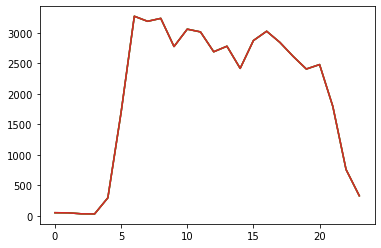

In [84]:
df.endTime = pd.to_datetime(df.endTime) 

freq = df.groupby(df['endTime'].dt.hour).count()
plt.plot(freq)
plt.show()

In [86]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-11-21 08:21:00,"Does It Offend You, Yeah?",We Are Rockstars,13744
1,2020-11-21 08:25:00,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),256170
2,2020-11-21 08:27:00,"Does It Offend You, Yeah?",We Are Rockstars,69343
3,2020-11-21 08:30:00,"Does It Offend You, Yeah?",Doomed Now,221133
4,2020-11-21 08:31:00,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,2603


Based on my habits, it is highly unlikely that I listen musit at 5am and 6am. This indicates that the timezone is not the one I live in: it seems the data are based on the UTC, whereas I live in the Europe/Berlin timezone.

# Dates & Time Transformations

In [87]:
# set the current time to UTC timezone
df['endTimeTz']= df.endTime.dt.tz_localize(tz='UTC')

# convert US Pacific to Europe/Berlin Timezone
df['endTimeTzEU']=df.endTimeTz.dt.tz_convert(tz='Europe/Berlin')

df['endTime']=df['endTimeTzEU'].apply(lambda d: d.replace(tzinfo=None))

df.drop(['endTimeTz', 'endTimeTzEU'], axis=1, inplace=True)

# additional time related transofmations 
df['hour'] = df['endTime'].dt.hour
df['date'] = df['endTime'].dt.to_period('D').apply(lambda r: r.start_time)
df['week'] = df['endTime'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['endTime'].dt.to_period('M').apply(lambda r: r.start_time)

# rounding up miliseconds Played to more readable formats
df['sPlayed'] = df['msPlayed']/(1000)
df['mPlayed'] = df['sPlayed']/(60)
df['hPlayed'] = df['sPlayed']/(60*60)

df.head()

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,hPlayed
0,2020-11-21 09:21:00,"Does It Offend You, Yeah?",We Are Rockstars,13744,9,2020-11-21,2020-11-16,2020-11-01,13.744,0.229067,0.003818
1,2020-11-21 09:25:00,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),256170,9,2020-11-21,2020-11-16,2020-11-01,256.170,4.269500,0.071158
2,2020-11-21 09:27:00,"Does It Offend You, Yeah?",We Are Rockstars,69343,9,2020-11-21,2020-11-16,2020-11-01,69.343,1.155717,0.019262
3,2020-11-21 09:30:00,"Does It Offend You, Yeah?",Doomed Now,221133,9,2020-11-21,2020-11-16,2020-11-01,221.133,3.685550,0.061426
4,2020-11-21 09:31:00,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,2603,9,2020-11-21,2020-11-16,2020-11-01,2.603,0.043383,0.000723


In [88]:
df.endTime.describe()

<ipython-input-88-38a75eb175bd>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.endTime.describe()


count                   47735
unique                  36102
top       2020-12-14 22:40:00
freq                       35
first     2020-11-21 09:21:00
last      2021-11-21 23:02:00
Name: endTime, dtype: object

In [89]:
df = df.loc[df['endTime'].dt.year == 2021]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40327 entries, 7408 to 47734
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   endTime     40327 non-null  datetime64[ns]
 1   artistName  40327 non-null  object        
 2   trackName   40327 non-null  object        
 3   msPlayed    40327 non-null  int64         
 4   hour        40327 non-null  int64         
 5   date        40327 non-null  datetime64[ns]
 6   week        40327 non-null  datetime64[ns]
 7   month       40327 non-null  datetime64[ns]
 8   sPlayed     40327 non-null  float64       
 9   mPlayed     40327 non-null  float64       
 10  hPlayed     40327 non-null  float64       
dtypes: datetime64[ns](4), float64(3), int64(2), object(2)
memory usage: 3.7+ MB


In [91]:
df.sort_values(by='endTime', inplace=True)
df.head()

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,hPlayed
7408,2021-01-01 06:01:00,Julia Wieniawa,Niezadowolona (piosenka do filmu „Wszyscy moi ...,44827,6,2021-01-01,2020-12-28,2021-01-01,44.827,0.747117,0.012452
7409,2021-01-01 06:01:00,Ariana Grande,god is a woman - live,31750,6,2021-01-01,2020-12-28,2021-01-01,31.750,0.529167,0.008819
7410,2021-01-01 06:04:00,Justin Bieber,Anyone,190779,6,2021-01-01,2020-12-28,2021-01-01,190.779,3.179650,0.052994
7411,2021-01-01 06:05:00,Justin Bieber,Anyone,9140,6,2021-01-01,2020-12-28,2021-01-01,9.140,0.152333,0.002539
7412,2021-01-01 06:08:00,Shawn Mendes,Monster (Shawn Mendes & Justin Bieber),178994,6,2021-01-01,2020-12-28,2021-01-01,178.994,2.983233,0.049721


In [72]:
df.tail()

,endTime,artistName,trackName,msPlayed,hour,date,week,month,sPlayed,mPlayed,hPlayed
47731,2021-11-21 22:44:00,Adele,Woman Like Me,0,22,2021-11-21,2021-11-15,2021-11-01,0.000,0.000000,0.000000
47730,2021-11-21 22:44:00,Adele,Hold On,2771,22,2021-11-21,2021-11-15,2021-11-01,2.771,0.046183,0.000770
47732,2021-11-21 22:44:00,Adele,Woman Like Me,94291,22,2021-11-21,2021-11-15,2021-11-01,94.291,1.571517,0.026192
47733,2021-11-21 22:51:00,Adele,Hold On,365965,22,2021-11-21,2021-11-15,2021-11-01,365.965,6.099417,0.101657
47734,2021-11-21 23:02:00,Adele,To Be Loved,696257,23,2021-11-21,2021-11-15,2021-11-01,696.257,11.604283,0.193405


# API Connector

In [66]:
cid = '0c4df4418a2e4290b3a4d7751665a215'
secret = 'ef84184c71b54774ab7cd04998973eca'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In this part I am picking one piece of data to see how certain Spotipy functions work and what type of results I get:

In [67]:
# simple check on one piece of data
artistName = 'Mr.Kitty'
trackName = 'After Dark'
searchQuery = trackName + ' ' + artistName
searchResults = sp.search(q=searchQuery, market="DE", limit=1, type='track')
searchResults

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=After+Dark+Mr.Kitty&type=track&market=DE&offset=0&limit=1',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0pWwt5vGNzezEhfAcc420Y'},
       'href': 'https://api.spotify.com/v1/artists/0pWwt5vGNzezEhfAcc420Y',
       'id': '0pWwt5vGNzezEhfAcc420Y',
       'name': 'Mr.Kitty',
       'type': 'artist',
       'uri': 'spotify:artist:0pWwt5vGNzezEhfAcc420Y'}],
     'external_urls': {'spotify': 'https://open.spotify.com/album/0PLo7Nd9uUa6shrWWOmJsQ'},
     'href': 'https://api.spotify.com/v1/albums/0PLo7Nd9uUa6shrWWOmJsQ',
     'id': '0PLo7Nd9uUa6shrWWOmJsQ',
     'images': [{'height': 640,
       'url': 'https://i.scdn.co/image/ab67616d0000b27385e3ceaa88ceb59eb9866b81',
       'width': 640},
      {'height': 300,
       'url': 'https://i.scdn.co/image/ab67616d00001e0285e3ceaa88ceb59eb9866b81',
       'width': 300},
      {'height': 64,
       'url': 'htt

In [68]:
track_id = searchResults['tracks']['items'][0]['id']
track_id

'0zCgWGmDF0aih5qexATyBn'

In [69]:
sp.audio_features(tracks=[track_id])

[{'danceability': 0.579,
  'energy': 0.601,
  'key': 8,
  'loudness': -10.492,
  'mode': 1,
  'speechiness': 0.0322,
  'acousticness': 0.0673,
  'instrumentalness': 0.414,
  'liveness': 0.0778,
  'valence': 0.0392,
  'tempo': 140.019,
  'type': 'audio_features',
  'id': '0zCgWGmDF0aih5qexATyBn',
  'uri': 'spotify:track:0zCgWGmDF0aih5qexATyBn',
  'track_href': 'https://api.spotify.com/v1/tracks/0zCgWGmDF0aih5qexATyBn',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0zCgWGmDF0aih5qexATyBn',
  'duration_ms': 257147,
  'time_signature': 4}]

In [70]:
# create list of unique artist-trackName pairs (to search through the API for)
search_list = df[['artistName', 'trackName']].drop_duplicates(ignore_index=True)
search_list = search_list.head(10)
search_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artistName  10 non-null     object
 1   trackName   10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


First getting track details - most importantly the ID - that will be later used for the audio features search.

Spotify funtion: sp.search()

#### !!!! LIST COLUMNS THAT I WILL SEARCH FOR !!!!


In [28]:
# timeit library to measure the time needed to run this code
start = timeit.default_timer()

# create empty lists where the results are going to be stored
artist_name = []
track_name = []
popularity = []
track_id = []

for row in search_list.iterrows():
    searchQuery = row[1][1] + ' ' + row[1][0]
    #print(searchQuery)
    search_results = sp.search(q=searchQuery, market="DE", limit=1, type='track')
    for i, t in enumerate(search_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

stop = timeit.default_timer()
print ('Time to run this code (in seconds):', stop - start)

Time to run this code (in seconds): 0.9572531440003331


In [29]:
df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})
print(df_tracks.shape)
df_tracks.head(15)

(10, 4)


,artist_name,track_name,track_id,popularity
0,"Does It Offend You, Yeah?",We Are Rockstars,6bntIooIQqoLRyPCLrhFQD,37
1,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),1khWWiRTVJXCwELtpxS1eh,27
2,"Does It Offend You, Yeah?",Doomed Now,2m49Uad3pkEz2n0lFCA5i5,18
3,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,4EyFxUSNHGpQuuoVh6D6kN,32
4,"Does It Offend You, Yeah?",Weird Science,2N7RvN0sLJ91zHwDGJgPHw,17
5,"Does It Offend You, Yeah?",Battle Royale,2k6F3ctTBlUXgtfCqbKvR1,21
6,"Does It Offend You, Yeah?",Attack Of The 60 Ft Lesbian Octopus,24r0RklFhcT1dy4giHxozf,19
7,"Does It Offend You, Yeah?",Dawn Of The Dead,5vBdLhZ14Ql1yoIn4fNFWq,39
8,"Does It Offend You, Yeah?",Epic Last Song,7DOG0pZhccXliUJSo4ZuYv,30
9,Lykke Li,Little Bit,0Ps4Eh6SQjeLnubbCsQTDD,69


Second API search: audio features using the track_id from the previous step

Spotipy function: sp.audio_features()

The function has a limit for a call of 100 track_ids, hence the loop also creates batches to iterate over whole list of songs I've listened to.

In [30]:
# again measuring the time
start = timeit.default_timer()

# empty list, batchsize and the counter for None results
rows = []
batchsize = 100
None_counter = 0

for i in range(0,len(df_tracks['track_id']),batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_results = sp.audio_features(batch)
    for i, t in enumerate(feature_results):
        if t == None:
            None_counter = None_counter + 1
        else:
            rows.append(t)
            
print('Number of tracks where no audio features were available:',None_counter)

stop = timeit.default_timer()
print ('Time to run this code (in seconds):',stop - start)

Number of tracks where no audio features were available: 0
Time to run this code (in seconds): 0.09011578999979974


In [31]:
df_audio_features = pd.DataFrame.from_dict(rows,orient='columns')
print("Shape of the dataset:", df_audio_features.shape)
df_audio_features.head()

Shape of the dataset: (10, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.603,0.954,10,-3.027,0,0.0417,0.000536,0.308000,0.2460,0.389,127.999,audio_features,6bntIooIQqoLRyPCLrhFQD,spotify:track:6bntIooIQqoLRyPCLrhFQD,https://api.spotify.com/v1/tracks/6bntIooIQqoL...,https://api.spotify.com/v1/audio-analysis/6bnt...,231634,4
1,0.653,0.934,8,-2.918,1,0.1200,0.000269,0.006580,0.0377,0.291,129.952,audio_features,1khWWiRTVJXCwELtpxS1eh,spotify:track:1khWWiRTVJXCwELtpxS1eh,https://api.spotify.com/v1/tracks/1khWWiRTVJXC...,https://api.spotify.com/v1/audio-analysis/1khW...,244027,4
2,0.512,0.917,1,-3.710,1,0.0388,0.000061,0.840000,0.1100,0.715,150.013,audio_features,2m49Uad3pkEz2n0lFCA5i5,spotify:track:2m49Uad3pkEz2n0lFCA5i5,https://api.spotify.com/v1/tracks/2m49Uad3pkEz...,https://api.spotify.com/v1/audio-analysis/2m49...,221133,4
3,0.504,0.904,6,-3.650,1,0.0555,0.000881,0.000034,0.0869,0.660,145.974,audio_features,4EyFxUSNHGpQuuoVh6D6kN,spotify:track:4EyFxUSNHGpQuuoVh6D6kN,https://api.spotify.com/v1/tracks/4EyFxUSNHGpQ...,https://api.spotify.com/v1/audio-analysis/4EyF...,245867,4
4,0.690,0.868,1,-3.695,1,0.1360,0.008360,0.149000,0.6320,0.777,127.981,audio_features,2N7RvN0sLJ91zHwDGJgPHw,spotify:track:2N7RvN0sLJ91zHwDGJgPHw,https://api.spotify.com/v1/tracks/2N7RvN0sLJ91...,https://api.spotify.com/v1/audio-analysis/2N7R...,304107,4


In [32]:
columns_to_drop = ['analysis_url','track_href','type','uri']
df_audio_features.drop(columns_to_drop, axis=1,inplace=True)

df_audio_features.rename(columns={'id': 'track_id'}, inplace=True)

df_audio_features.shape

(10, 14)

In [33]:
# merge both dataframes
# the 'inner' method will make sure that we only keep track IDs present in both datasets
df_tracks_catalog = pd.merge(df_tracks,df_audio_features,on='track_id',how='inner')
print("Shape of the dataset:", df_audio_features.shape)
df_tracks_catalog.head()

Shape of the dataset: (10, 14)


,artist_name,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,"Does It Offend You, Yeah?",We Are Rockstars,6bntIooIQqoLRyPCLrhFQD,37,0.603,0.954,10,-3.027,0,0.0417,0.000536,0.308000,0.2460,0.389,127.999,231634,4
1,"Does It Offend You, Yeah?",With A Heavy Heart (I Regret To Inform You),1khWWiRTVJXCwELtpxS1eh,27,0.653,0.934,8,-2.918,1,0.1200,0.000269,0.006580,0.0377,0.291,129.952,244027,4
2,"Does It Offend You, Yeah?",Doomed Now,2m49Uad3pkEz2n0lFCA5i5,18,0.512,0.917,1,-3.710,1,0.0388,0.000061,0.840000,0.1100,0.715,150.013,221133,4
3,"Does It Offend You, Yeah?",Being Bad Feels Pretty Good,4EyFxUSNHGpQuuoVh6D6kN,32,0.504,0.904,6,-3.650,1,0.0555,0.000881,0.000034,0.0869,0.660,145.974,245867,4
4,"Does It Offend You, Yeah?",Weird Science,2N7RvN0sLJ91zHwDGJgPHw,17,0.690,0.868,1,-3.695,1,0.1360,0.008360,0.149000,0.6320,0.777,127.981,304107,4
